<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Random_forest_Modular_Correct(Daily_New).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [654]:
! git clone https://github.com/anirbanghoshsbi/pandas-technical-indicators.git

Cloning into 'pandas-technical-indicators'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 202 (delta 105), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (202/202), 58.64 KiB | 1017.00 KiB/s, done.
Resolving deltas: 100% (117/117), done.


In [655]:
!pwd

/content/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators


In [656]:
%cd pandas-technical-indicators

/content/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators


In [ ]:
#!pip install yfinance

In [658]:
# Import libraries
import os
import sys
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [659]:
import technical_indicators as ta
import random_forest as rf
import confusionMatrix as cm
import easy_line_ploting as linplt

In [762]:
tickr ='^nsei'   #'^NSEI' #^NSEBANK  #^cnxit #^GSPC #^YHOH714

In [763]:
df_old = pd.DataFrame()

In [764]:
df_old = yf.download(tickr,'2008-01-01','2017-05-01')

[*********************100%***********************]  1 of 1 completed


In [765]:
df_old.shape

(2270, 6)

# INPUT

In [766]:
# INPUT .........

#  ********************************* #

t=2
days_out=14


#  ********************************* #

In [767]:
def get_indicators(data ,days_out,t=1):
    data = ta.relative_strength_index(data,days_out)
    #data=ta.exponential_moving_average(data,10*t)
    data=ta.exponential_moving_average(data,50*t)
    data=ta.momentum(data,7*t)
    data=ta.rate_of_change(data,7*t)
    data=ta.exponential_moving_average(data,7*t)
    
    data=ta.exponential_moving_average(data , 10*t)
    data=ta.exponential_moving_average(data ,20*t)
    data=ta.force_index(data ,days_out)
    data = ta.on_balance_volume(data , days_out)
    data = ta.standard_deviation(data , days_out)
    data = ta.stochastic_oscillator_d(data ,days_out)
    data = ta.stochastic_oscillator_k(data)
    data = ta.macd(data , 9 , 12)
    data = ta.ppsr(data)
    data = ta.trix(data,days_out)
    data = ta.vortex_indicator(data , days_out)
    data = ta.find_window_high_low(data,days_out)
    #data = ta.keltner_channel(data , 13)
    #data['change_in_price'] = data['Close'].diff()
    
    return data


# Check This For Weekly or Daily 

In [768]:
############################ Comment or Uncomment Based on Daily or Weekly ##########

#df_old=df_old.resample('W').last()

In [769]:
train=int(len(df_old)*.75)
df_train= df_old[:train]
df_test= df_old[train+50:]

In [770]:
df_train.shape , df_test.shape

((1702, 6), (518, 6))

In [771]:
df_train = get_indicators(df_train,days_out,1)
df_test= get_indicators(df_test,days_out,1)

In [772]:
df_old.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-27,9359.150391,9367.150391,9322.650391,9342.150391,9342.150391,209400
2017-04-28,9340.950195,9342.650391,9282.250000,9304.049805,9304.049805,162200


In [773]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()

In [774]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_test = df_test.dropna()

In [775]:
X_train = df_train.drop(['Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [776]:
############## JUST REMOVE # TO COMPUTE THE BEST PARAMETERS #######################

#rf.best_param_rf(X_train , y_train , 100)

In [777]:
'''
>>> 100 iterations
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished
{'Best Score': 0.9169554134840112,
 'Best parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 60,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 7,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 200,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  
>>> for n_iter=300
{'Best Score': 0.9654412531082027,
 'Best parameters': {'bootstrap': False,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 10,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 16,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 1800,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  '''

"\n100 iterations\n{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}\nFitting 3 folds for each of 100 candidates, totalling 300 fits\n[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.\n[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min\n[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min\n[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished\n{'Best Score': 0.9169554134840112,\n 'Best parameters': {'bootstrap': True,\n  'ccp_alpha': 0.0,\n  'class_weight': None,\n  'criterion': 'gini',\n  'max_depth': 60,\n  'max_features': None,\n  'max_leaf_nodes': None,\n  'max_samples': None,\n  'min_impurity_decrease': 0.0,\n  'min_impurity_split': None,\n  'min_samples_leaf': 7,\n  'min_sa

In [778]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=80,min_samples_leaf=2,max_features='auto', min_samples_split=2, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)


In [779]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction RForest (%):  92.96375266524521


Accuracy: 92.96375266524521
Percision: 93.12714776632302
Recall: 95.4225352112676
Specificity: 89.1891891891892


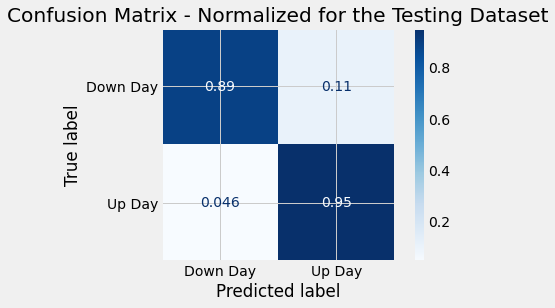

In [780]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True )

#cm.confus_matrix(actual_results , predictions,model ,<test data ( or new_data for prediction except target VAR)>, <actaul Target VAR> , <plot=True>)

In [781]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns

# Logistic Regression

In [782]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [783]:
LogReg = LogisticRegression()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
LogReg.fit(X_train, y_train)
y_predL = LogReg.predict(X_test)

In [784]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, LogReg.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  96.37526652452026


Accuracy: 96.37526652452026
Percision: 94.64882943143813
Recall: 99.64788732394366
Specificity: 91.35135135135135


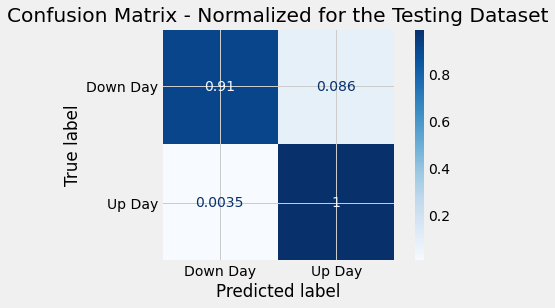

In [785]:
cm.confus_matrix(y_test,y_predL,LogReg,X_test,y_test,plot=True )

# Support Vector Classifier

In [786]:
from sklearn.svm import SVC
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
svc_classifier = SVC(kernel = 'linear', random_state = 0)
svc_classifier.fit(X_train, y_train)
y_predS = svc_classifier.predict(X_test)

In [787]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, svc_classifier.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  95.73560767590618


Accuracy: 95.73560767590618
Percision: 94.0
Recall: 99.29577464788733
Specificity: 90.27027027027027


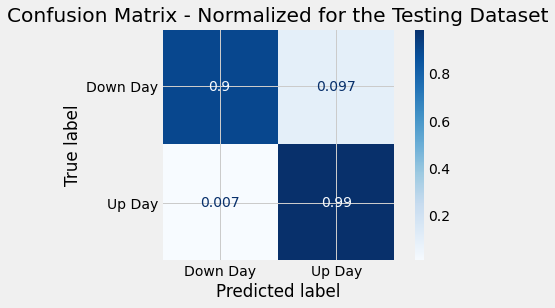

In [788]:
cm.confus_matrix(y_test,y_predS,svc_classifier,X_test,y_test,plot=True )

# XGBoost Classifier

In [789]:
import xgboost as xgb

In [790]:
'''
param_test1 = {
 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],
 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],
 'n_estimators': [10,50,100,200,300]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)
 
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_
'''

"\nparam_test1 = {\n 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],\n 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],\n 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],\n 'n_estimators': [10,50,100,200,300]\n}\ngsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)\n \ngsearch1.fit(X_train,y_train)\ngsearch1.best_params_, gsearch1.best_score_\n"

In [791]:
xgb_classifier = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_classifier.fit(X_train, y_train)
y_predX = xgb_classifier.predict(X_test)
print("Accuracy for XGBoost Model: %.2f" % (accuracy_score(y_test, y_predX) * 100))

Accuracy for XGBoost Model: 92.96


Accuracy: 92.96375266524521
Percision: 92.54237288135593
Recall: 96.12676056338029
Specificity: 88.10810810810811


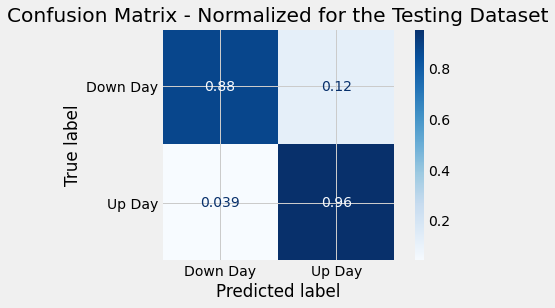

In [792]:
cm.confus_matrix(y_test,y_predX,xgb_classifier,X_test,y_test,plot=True )

In [793]:
feature_imp_XGB = pd.Series(xgb_classifier.feature_importances_, index=feats).sort_values(ascending=False)
feature_imp_XGB*100

Vortex_14                   32.918293
MACD_9_12                   15.351174
SO%k                         3.592744
RSI_14                       3.136558
OBV_14                       2.784700
Open                         2.461052
Force_14                     2.303015
Volume                       2.289428
SO%d_14                      2.135508
ROC_7                        2.125563
Trix_14                      1.984674
STD_14                       1.880042
R2                           1.790153
EMA_7                        1.709536
EMA_20                       1.699930
MACDsign_9_12                1.673359
MACDdiff_9_12                1.651230
Win_Low                      1.604389
PP                           1.566919
High                         1.526642
Momentum_7                   1.512126
EMA_50                       1.478879
Close                        1.406081
S1                           1.316577
S3                           1.302675
Low                          1.156920
R3          

In [794]:
features = {'Random Forest' : feature_imp,'XGBoost': feature_imp_XGB}
feats=pd.DataFrame(features)

In [795]:
feats.sort_values(by=['XGBoost'],ascending=False)

,Random Forest,XGBoost
Vortex_14,0.238892,0.329183
MACD_9_12,0.208340,0.153512
SO%k,0.012929,0.035927
RSI_14,0.128031,0.031366
OBV_14,0.017172,0.027847
Open,0.004035,0.024611
Force_14,0.001792,0.023030
Volume,0.002652,0.022894
SO%d_14,0.044609,0.021355
ROC_7,0.040199,0.021256


# Make Actual Prediction

In [796]:
df = pd.DataFrame()

In [797]:
df = yf.download(tickr,'2019-01-01')

[*********************100%***********************]  1 of 1 completed


In [798]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-15,17387.650391,17532.699219,17386.900391,17519.449219,17519.449219,388200
2021-09-16,17539.199219,17644.599609,17510.449219,17629.500000,17629.500000,503300
2021-09-17,17709.650391,17792.949219,17537.650391,17585.150391,17585.150391,0


# Check This For Weekly or Daily

In [799]:
####################### Comment or Uncomment Based on Weekly or Daily ##################
#df=df.resample('W').last()

In [800]:
df = get_indicators(df,days_out,1)
#df= impulse(df)

In [801]:
df.tail(2)

,Open,High,Low,Close,Adj Close,Volume,RSI_14,EMA_50,Momentum_7,ROC_7,EMA_7,EMA_10,EMA_20,Force_14,OBV_14,STD_14,SO%d_14,SO%k,MACD_9_12,MACDsign_9_12,MACDdiff_9_12,PP,R1,S1,R2,S2,R3,S3,Trix_14,Vortex_14,Win_High,Win_Low,Signals_from_Window_HiLo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-16,17539.199219,17644.599609,17510.449219,17629.500000,17629.500000,503300,0.848398,16574.905482,251.699219,0.015401,17429.504748,17352.877627,17103.438304,2.479514e+08,144385.714286,238.951744,0.687359,0.887443,77.663447,79.088987,-1.425540,17594.849609,17679.250000,17545.099609,17729.000000,17460.699219,17813.400391,17410.949219,0.002856,0.857552,17532.699219,16565.599609,1.0
2021-09-17,17709.650391,17792.949219,17537.650391,17585.150391,17585.150391,0,0.884627,16614.522929,223.050781,0.013349,17468.416159,17395.109039,17149.315645,-1.913014e+08,128857.142857,190.371670,0.620519,0.186056,75.244246,78.320039,-3.075793,17638.583333,17739.516276,17484.217448,17893.882161,17383.284505,17994.815104,17228.918620,0.002871,0.899239,17644.599609,16565.599609,0.0


In [802]:
df_old.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-01,6136.750000,6165.350098,6109.850098,6144.350098,6144.350098,0
2008-01-02,6144.700195,6197.000000,6060.850098,6179.399902,6179.399902,0


In [803]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df['Signal_Flag'] = df['Close'].transform(lambda x : np.sign(x.diff(days_out)))

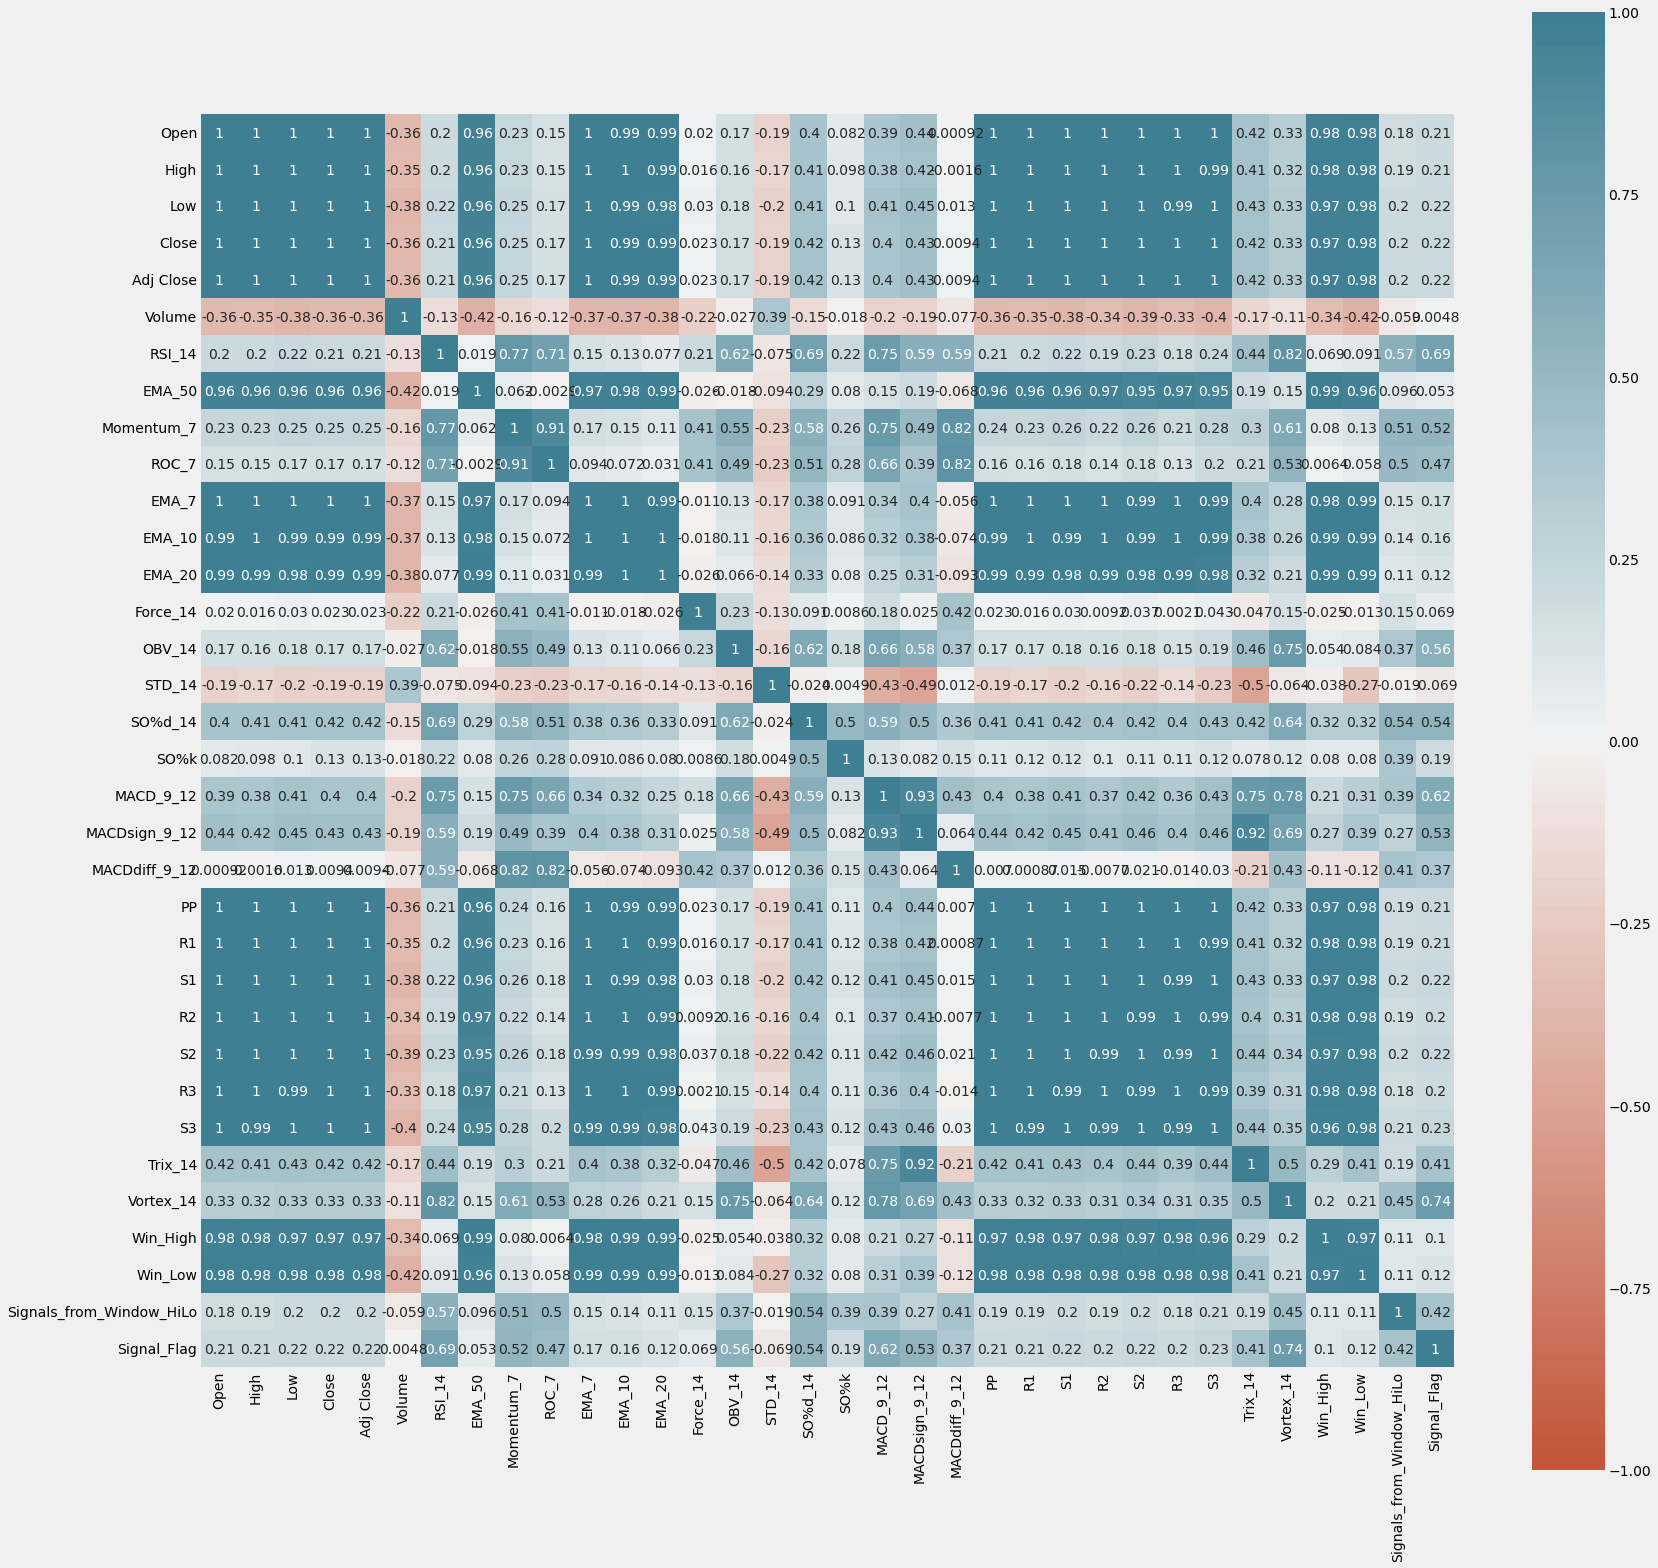

In [804]:
ta.correlation_map(df,25)

In [805]:
df.shape

(666, 34)

In [806]:
df=df.dropna()

In [807]:
df.shape

(617, 34)

In [808]:
new_data = df.drop(['Signal_Flag'],axis=1)
actuals= df['Signal_Flag']


# Make Predictions Using Random Forest

In [809]:
model='random_forest'

In [810]:
preds=rf.make_preds(new_data ,rand_frst_clf,model,df)

In [811]:
print("days_out : ",days_out)

days_out :  14


In [812]:
preds.head(2)

,predsrandom_forest
Date,
2019-03-14,1.0
2019-03-15,1.0


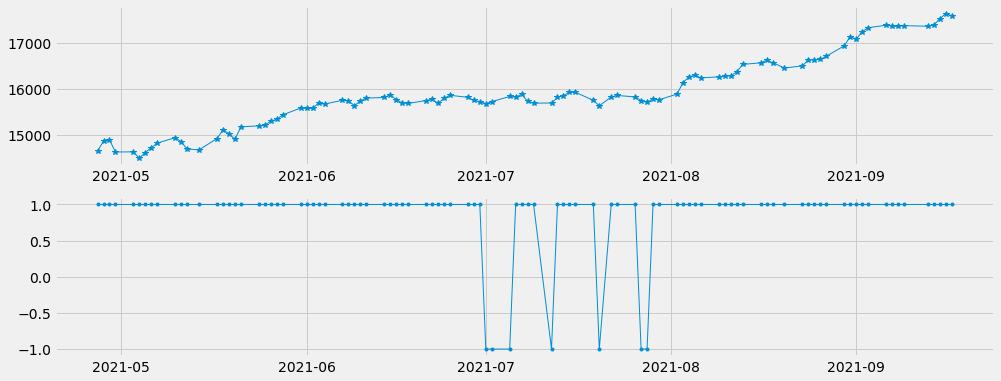

In [813]:
linplt.lineplot(2,15,6,df,preds['predsrandom_forest'], no_of_datapoints=100) # no_of_datapoints=100

In [814]:
pred = pd.DataFrame(rf.make_preds(new_data , rand_frst_clf, model,df))

In [815]:
pred.head(2)

,predsrandom_forest
Date,
2019-03-14,1.0
2019-03-15,1.0


In [816]:
pred = pd.concat([pred ,df.Close],axis=1)
#pred.columns=['Date','preds','Close']
#pred= pred.set_index('Date')

In [817]:
l= len(pred)

In [818]:
#fig, ax = plt.subplots(1,1,figsize=(20,7))
#Identifying the buy/sell zone
pred['Buy_ind'] = np.where((pred['predsrandom_forest']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['predsrandom_forest']==-1), 0, 1)

In [819]:
pred=pred.reset_index()

# Make Prediction Using XGBoost

In [820]:
model='_XGB'

In [821]:
predX=rf.make_preds(new_data.values ,xgb_classifier,model,df)

In [822]:
predX= pd.concat([predX ,df.Close],axis=1)

In [823]:
predX.head(2)

,preds_XGB,Close
Date,,
2019-03-14,1.0,11343.250000
2019-03-15,1.0,11426.849609


In [824]:
#Identifying the buy/sell zone
predX['Buy_ind_XGB'] = np.where((predX['preds_XGB']==1), 1, 0)
predX['Sell_ind_XGB'] = np.where((predX['preds_XGB']==-1), 0, 1)

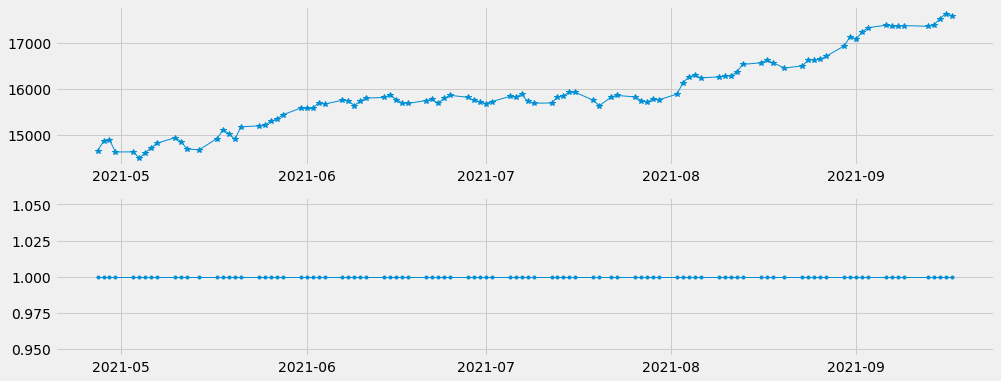

In [825]:
linplt.lineplot(2,15,6,df,predX['preds_XGB'], no_of_datapoints=100) # no_of_datapoints=100

In [826]:
predX=predX.reset_index()

# Make Prediction Using Logistics Regression

In [827]:
model='_Logistic_Regression'

In [828]:
preds_logreg=pd.DataFrame(rf.make_preds(new_data , LogReg,model, df))

In [829]:
preds_logreg.head(2)

,preds_Logistic_Regression
Date,
2019-03-14,-1.0
2019-03-15,-1.0


In [830]:
predL = pd.concat([preds_logreg ,df.Close],axis=1)

In [831]:
predL=predL.reset_index()

In [832]:
#Identifying the buy/sell zone
predL['Buy_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==1), 1, 0)
predL['Sell_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==-1), 0, 1)

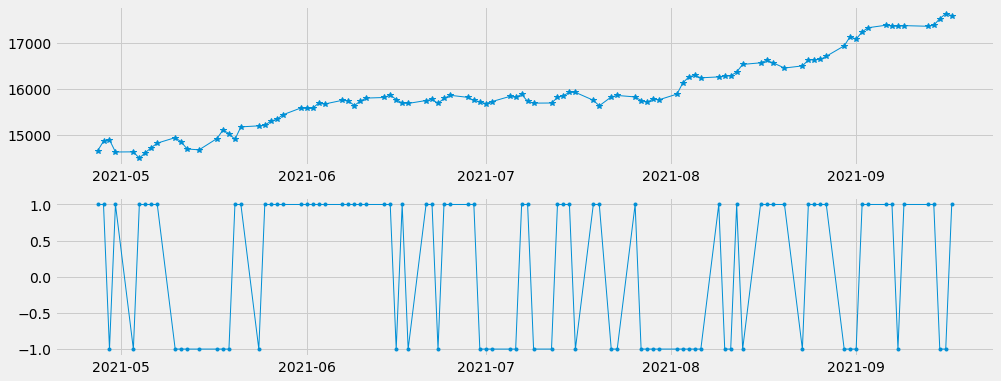

In [833]:
linplt.lineplot(2,15,6,df,preds_logreg['preds_Logistic_Regression'], no_of_datapoints=100) # no_of_datapoints=100

# Make Predictions using Support Vector Classifier

In [834]:
model='_SVC'

In [835]:
preds_svc=pd.DataFrame(rf.make_preds(new_data ,svc_classifier,model, df))

In [836]:
predS = pd.concat([preds_svc,df.Close],axis=1)

In [837]:
predS=predS.reset_index()

In [838]:
#Identifying the buy/sell zone
predS['Buy_ind_SVC'] = np.where((predS['preds_SVC']==1), 1, 0)
predS['Sell_ind_SVC'] = np.where((predS['preds_SVC']==-1), 0, 1)

# PREDICTIONS

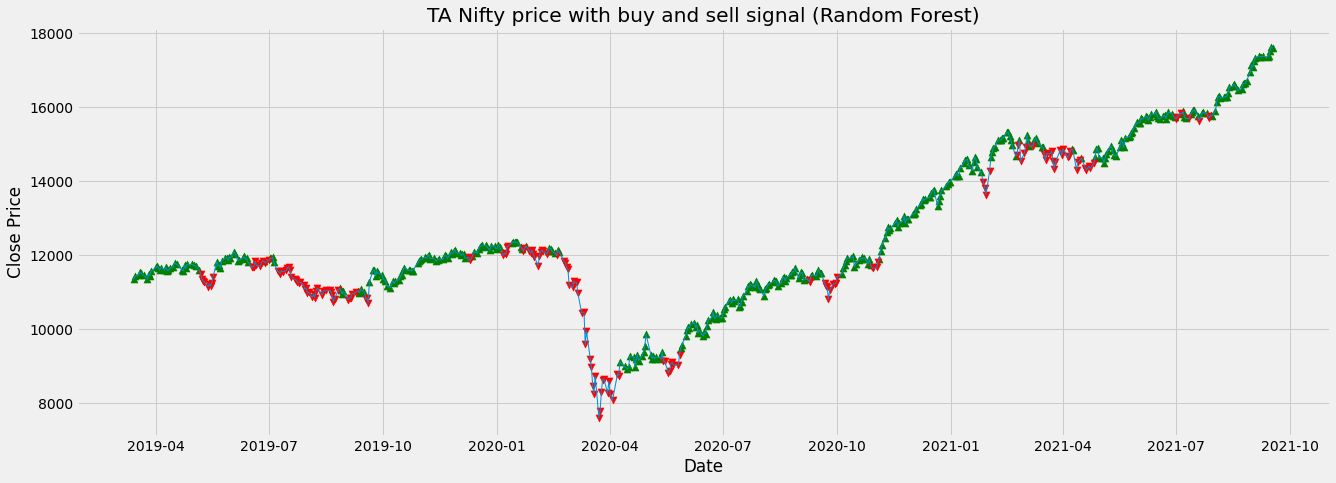

In [839]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(pred.loc[pred['Buy_ind'] ==1 , 'Date'].values,pred.loc[pred['Buy_ind'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ind'] ==0 , 'Date'].values,pred.loc[pred['Sell_ind'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Random Forest)') 

plt.savefig('a.png')
plt.show();

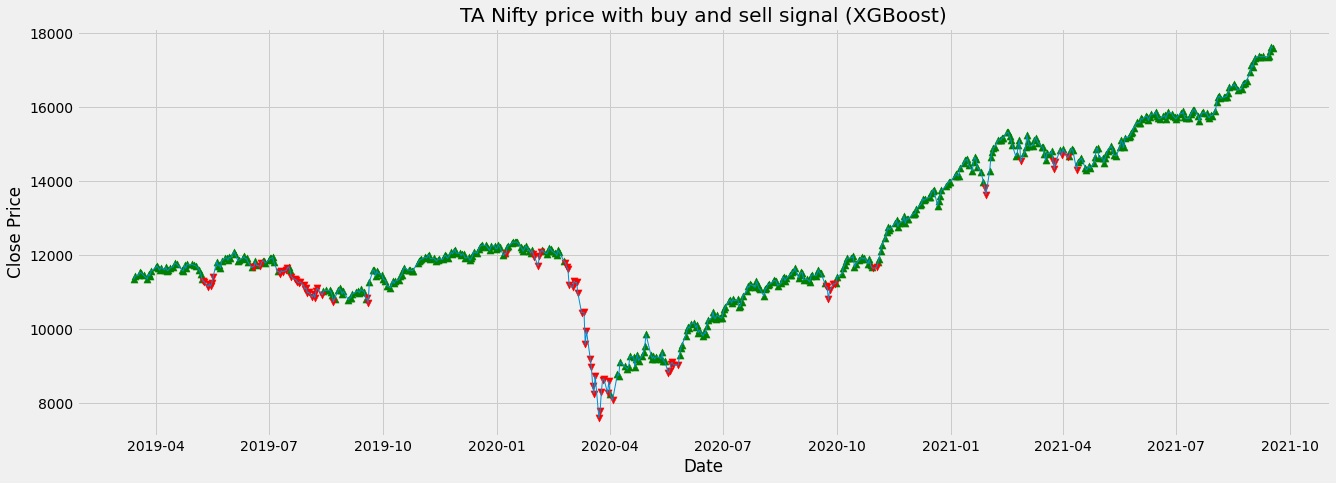

In [840]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predX.loc[predX['Buy_ind_XGB'] ==1 , 'Date'].values,predX.loc[predX['Buy_ind_XGB'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predX.loc[predX['Sell_ind_XGB'] ==0 , 'Date'].values,predX.loc[predX['Sell_ind_XGB'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (XGBoost)') 

plt.savefig('a.png')
plt.show();

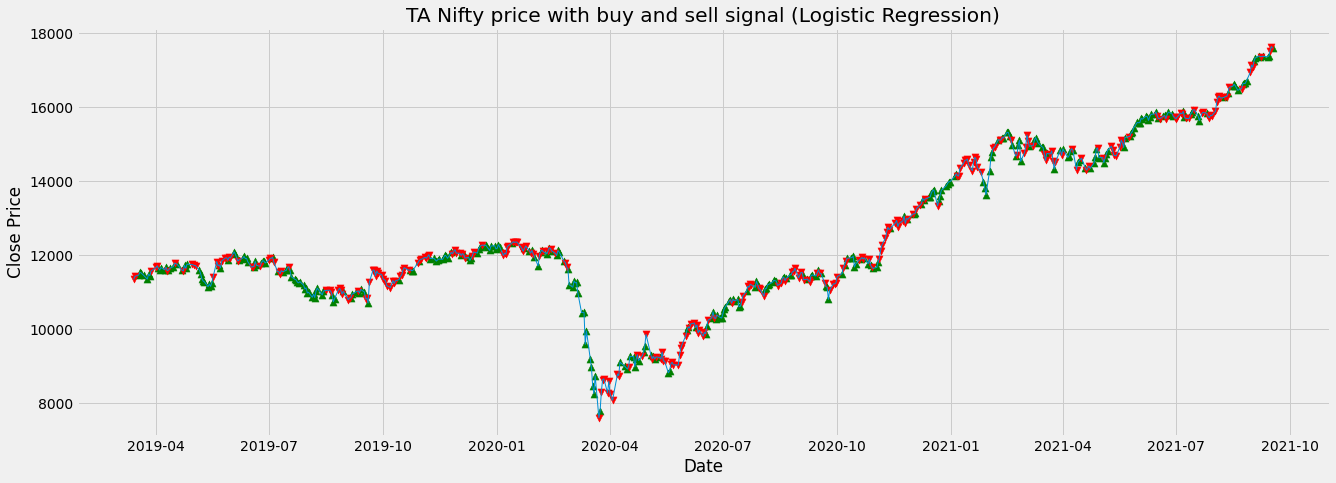

In [841]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predL.loc[predL['Buy_ind_Logreg'] ==1 , 'Date'].values,predL.loc[predL['Buy_ind_Logreg'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predL.loc[predL['Sell_ind_Logreg'] ==0 , 'Date'].values,predL.loc[predL['Sell_ind_Logreg'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Logistic Regression)') 

plt.savefig('a.png')
plt.show();

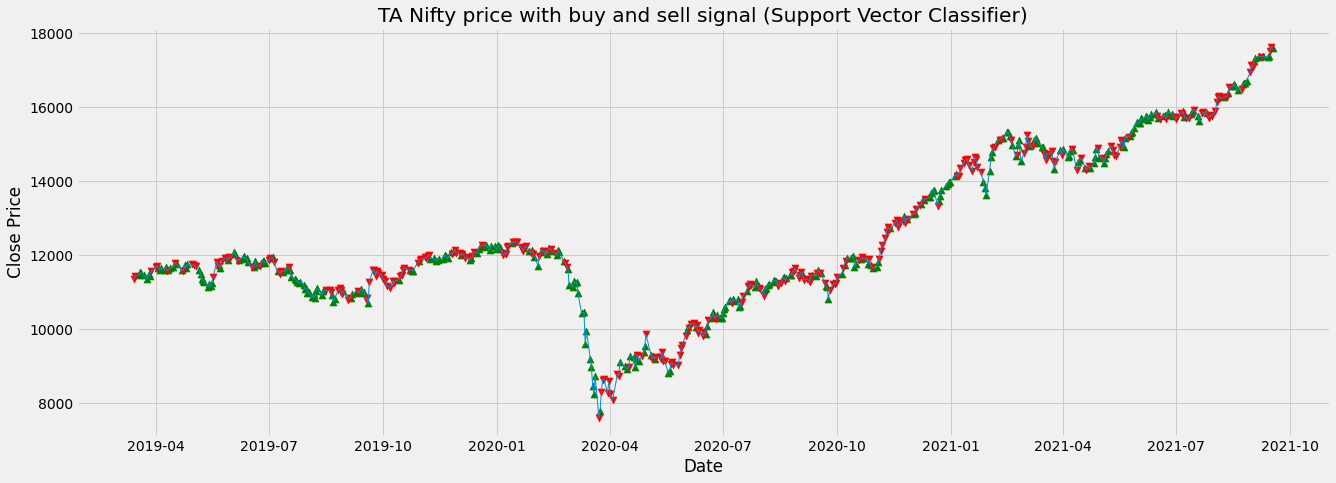

In [842]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predS.loc[predS['Buy_ind_SVC'] ==1 , 'Date'].values,predS.loc[predS['Buy_ind_SVC'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predS.loc[predS['Sell_ind_SVC'] ==0 , 'Date'].values,predS.loc[predS['Sell_ind_SVC'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Support Vector Classifier)') 

plt.savefig('a.png')
plt.show();

In [843]:
pred['ensemble'] = pred['predsrandom_forest']*1.0+predL['preds_Logistic_Regression']*0.25+predS['preds_SVC']*0.25+predX['preds_XGB']*0.5

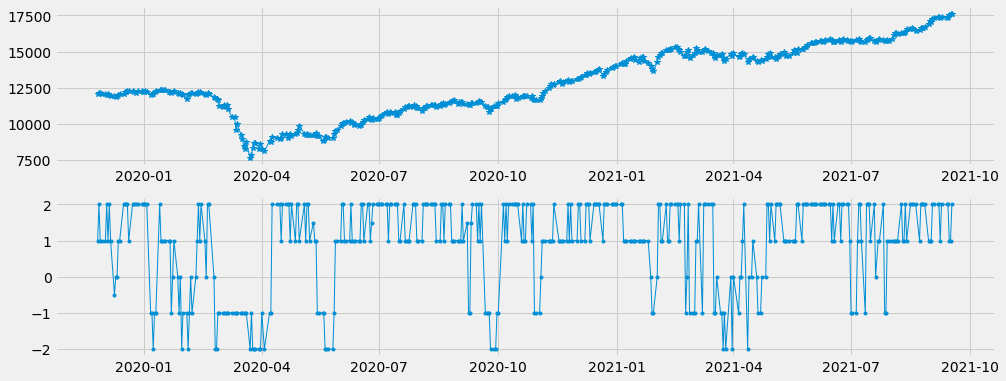

In [844]:
linplt.lineplot(2,15,6,df,pred['ensemble'], no_of_datapoints=450) # no_of_datapoints=100

In [845]:
#pred['Signal_from_close']=np.where((pred.Close>pred.Close.shift(1)),1,0)

In [846]:
#Identifying the buy/sell zone
pred['Buy_ensemble'] = np.where((pred['ensemble']>=0), 1, 0)
pred['Sell_ensemble'] = np.where((pred['ensemble']<0), 0, 1)
#pred['Neutral'] = np.where((pred['ensemble']==-0.5),0,1)
pred['signal4theday']= np.where((pred['ensemble']>=0),1,0)

In [847]:
pred['signalF']=pred['signal4theday']

In [848]:
pred.to_csv('rf_ta.csv')

In [849]:
def plot_me_buy_sell_signal(pred,small_period,large_period):
  buy=[]
  sell=[]
  for i in range(len(pred)):
    if pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i]>pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i] and \
    pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i-1]<pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i-1]:
      buy.append(i)
    elif pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i]<pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i] and \
    pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i-1]>pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i-1]:
      sell.append(i)
  
  return buy,sell

In [850]:
buy,sell=plot_me_buy_sell_signal(pred,10,30)

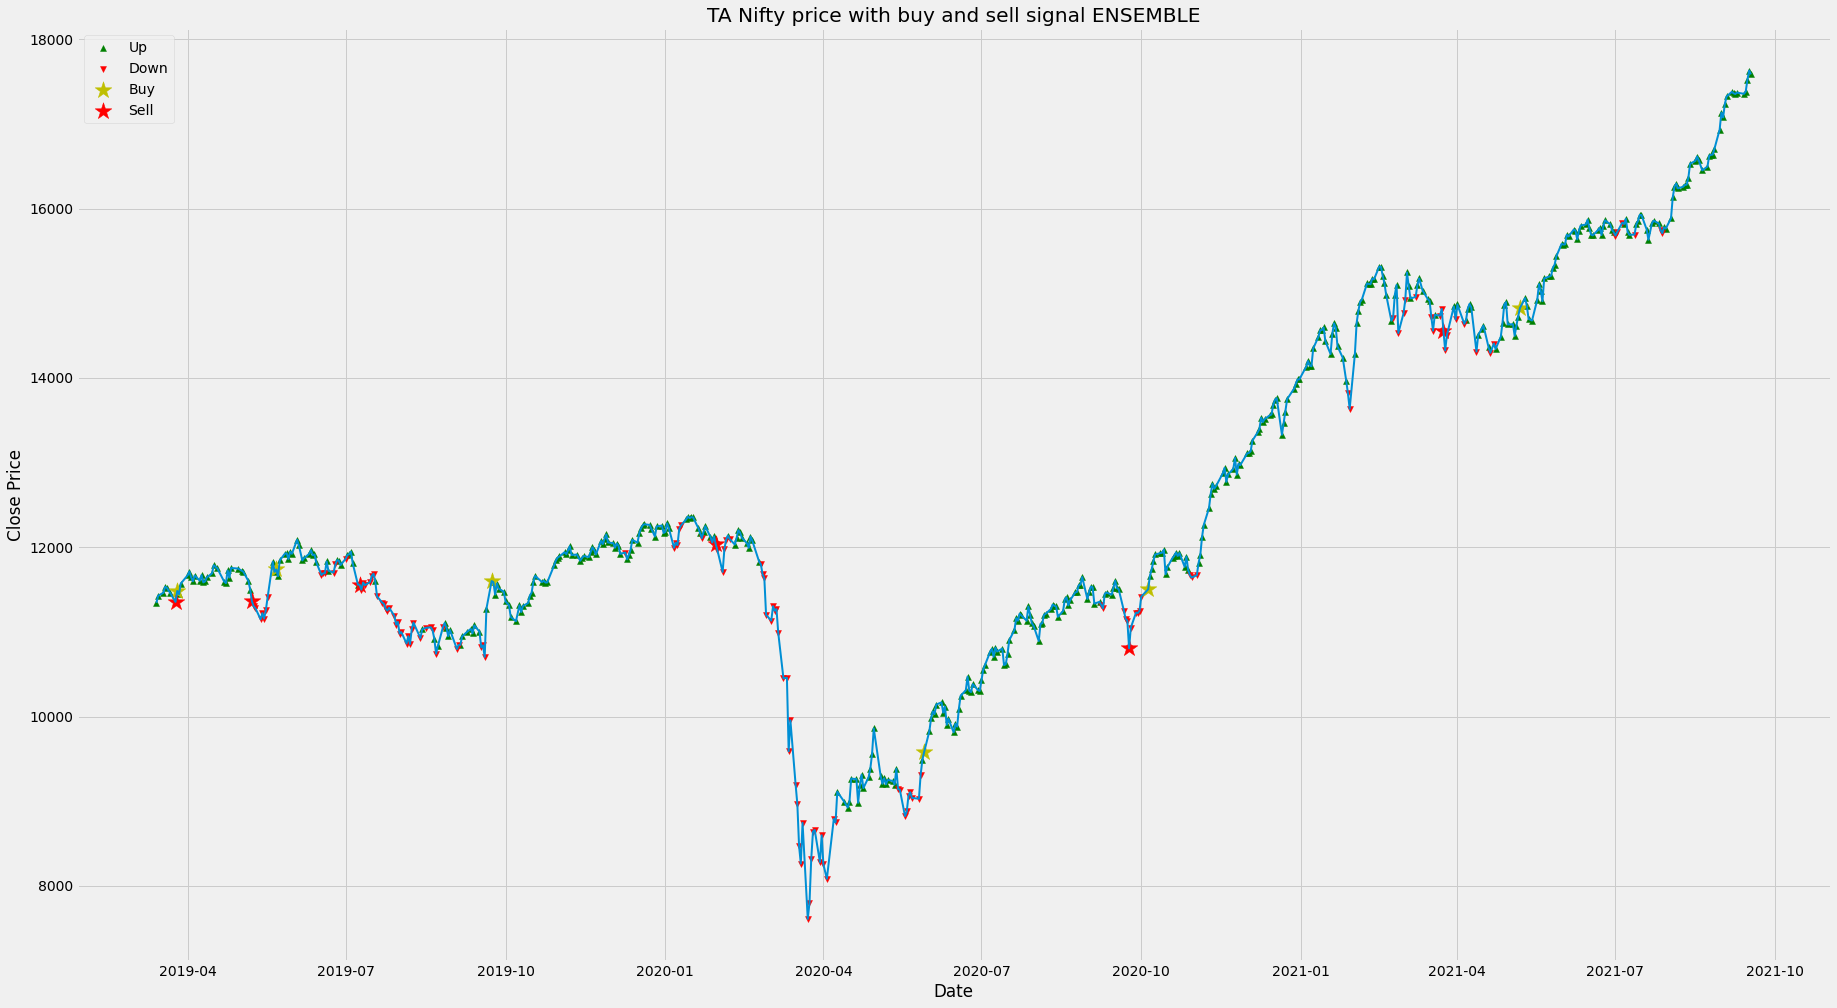

In [851]:
plt.figure(figsize=(28,16))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(pred.loc[pred['Buy_ensemble'] ==1 , 'Date'].values,pred.loc[pred['Buy_ensemble'] ==1, 'Close'].values, label='Up', color='green', s=35, marker="^")
plt.scatter(pred.loc[pred['Sell_ensemble'] ==0 , 'Date'].values,pred.loc[pred['Sell_ensemble'] ==0, 'Close'].values, label='Down', color='red', s=35, marker="v")
#plt.scatter(pred.loc[pred['Neutral'] ==0 , 'Date'].values,pred.loc[pred['Neutral'] ==0, 'Close'].values, label='skitscat', color='blue', s=50, marker="*")
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=305,color='y',label='Buy')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='*',s=305,color='r',label='Sell')
#plt.plot(df.index,df['EMA_20'].values[-l:],label='EMA 20')
#plt.plot(df.index,df['EMA_10'].values[-l:], label='EMA 10')

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price') 
plt.legend(loc='upper left') 
plt.title('TA Nifty price with buy and sell signal ENSEMBLE') 
plt.show();

Accuracy: 93.51701782820098
Percision: 92.97052154195012
Recall: 97.85202863961814
Specificity: 84.34343434343434


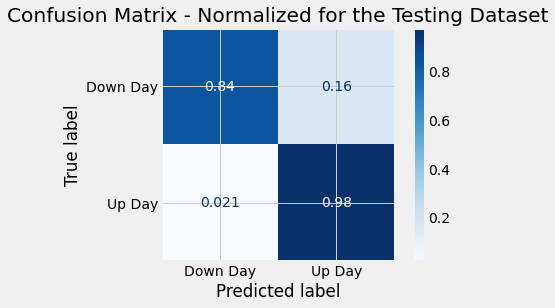

In [852]:
cm.confus_matrix(df.Signal_Flag,preds,rand_frst_clf,new_data,actuals,plot=True )


Accuracy: 92.96375266524521
Percision: 93.12714776632302
Recall: 95.4225352112676
Specificity: 89.1891891891892


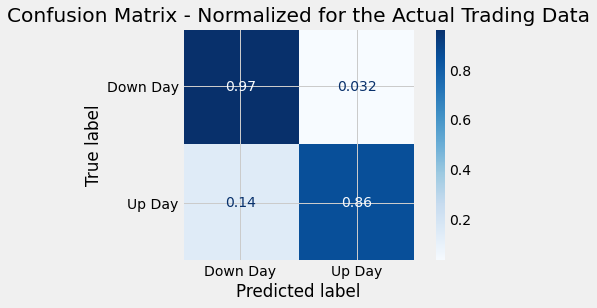

In [853]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True, test=False)


In [854]:
# saving the dataframe
pred[['Date','signalF']].to_csv('/content/rf_TA.csv')

In [855]:
pred.head(1)

,Date,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Buy_ensemble,Sell_ensemble,signal4theday,signalF
0,2019-03-14,1.0,11343.25,1,1,1.0,1,1,1,1


In [856]:
pred.set_index('Date',inplace=True)

In [857]:
pred.tail(2)

,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Buy_ensemble,Sell_ensemble,signal4theday,signalF
Date,,,,,,,,,
2021-09-16,1.0,17629.500000,1,1,1.0,1,1,1,1
2021-09-17,1.0,17585.150391,1,1,2.0,1,1,1,1


In [858]:
pred['actual']=np.where(pred.Close>pred.Close.shift(1),1,0)
pred['dummy']= np.where(pred.signal4theday==0,0,1)
pred['dummyS']=pred['dummy'].shift(1)
pred=pred.dropna()

In [859]:
pred.signalF.value_counts()

1    478
0    138
Name: signalF, dtype: int64

In [860]:
pred.dummyS.value_counts()

1.0    478
0.0    138
Name: dummyS, dtype: int64

In [861]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(pred.actual, pred.dummyS)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(pred.actual, pred.dummyS)

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1score= 2*recall*percision/(percision+recall)
print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {}'.format(float(f1score)))
print('Average Precision : {}'.format(float(average_precision)))

Accuracy: 0.5324675324675324
Percision: 0.5627615062761506
Recall: 0.7729885057471264
Specificity: 0.22014925373134328
F1-Score: 0.6513317191283293
Average Precision : 0.5632549290751571


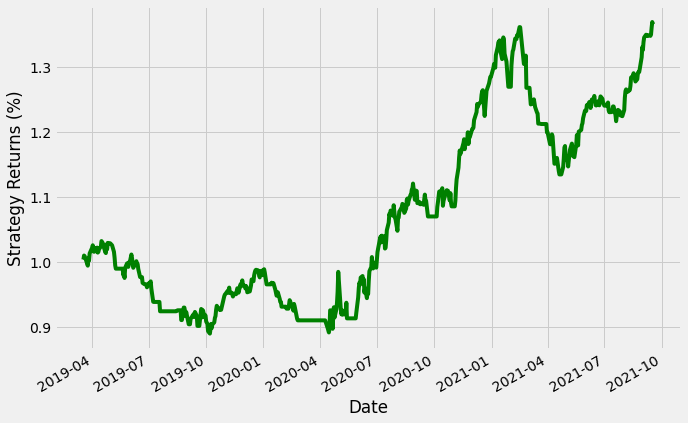

In [862]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_Return'] = pred.Return * pred.dummy.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_Return+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()

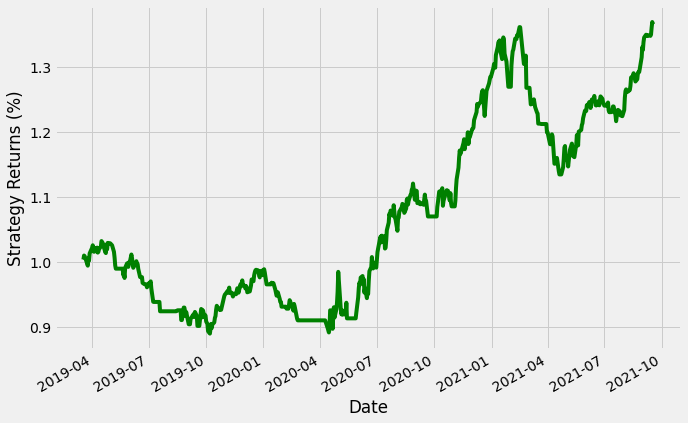

In [863]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_F'] = pred.Return * pred.signalF.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_F+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()